# Assignment 3: Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion.

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following seven steps.
Provide answers for each sub-question by thorough analysis and extensive experimental investigation using the provided dataset. In other words, your answers should be backed by experimental analysis of your models and the dataset. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

**1. Prepare and Preprocess the data. (15 points)**

1. What is the total number of images in the dataset, and how are they distributed across the five flower types?

2. Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?

3. What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?

4. What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?

5. How would you split the dataset into training, validation and testing sets, and in what ratios?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

zip_path = "/content/drive/MyDrive/Assignment3/flowers.zip"
extracted_folder = "/content/drive/MyDrive/Assignment3"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

Mounted at /content/drive


In [ ]:
# Step 1 implementation
# Hint: Take the help of split-folder python library
# Import necessary modules
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from sklearn.utils import resample
from torch.utils.data import Subset
import cv2
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.transforms import GaussianBlur
from collections import Counter
from torch.utils.data import WeightedRandomSampler
# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Compute the data augmentations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),# Cifar-10 normalise
])

# Specify the data load path and load them with transformations applied
data_dir = '/content/drive/MyDrive/Assignment3/flowers'
classes = os.listdir(data_dir)
print(f'Classes: {classes}')
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Print shape of image input
img, label = dataset[100]
print(f'Size of image:{img.shape}')

total = len(dataset)
class_counts = Counter([label for _, label in dataset])
class_names = dataset.classes

print(f"Number of images: {total}")
for class_name, count in zip(class_names, class_counts.values()):
    print(f"{class_name.upper()}: {count} images")


Classes: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']
Size of training dataset : 4317
Size of image:torch.Size([3, 224, 224])
Number of images: 4317
DAISY: 764 images
DANDELION: 1052 images
ROSE: 784 images
SUNFLOWER: 733 images
TULIP: 984 images


In [ ]:
# Define the batch size
batch_size = 32

max_count = max(class_counts.values())
class_indices = {class_idx: np.where(np.array(dataset.targets) == class_idx)[
    0] for class_idx in class_counts.keys()}
oversampled_indices = []

for class_idx, indices in class_indices.items():
    if len(indices) < max_count:
        oversampled_indices.extend(
            resample(indices, replace=True, n_samples=max_count - len(indices)))
print(f'Oversampling applied.')
b_indices = list(range(total)) + oversampled_indices
b_dataset = Subset(dataset, b_indices)
train_size = int(0.9 * len(b_dataset))
val_size = int(0.05 * len(b_dataset))
test_size = len(b_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(
    b_dataset, [train_size, val_size, test_size])
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, pin_memory=True)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Oversampling applied.


From the printed numbers of images in each class, there are no significant variations, indicating that a oversampling may not be necessary, but I still applied here hopefully for any improvment in performances. I also utilised the data augmentation for image processing so that the model can hopefully avoid overfitting. I also added some data augmentation and normalising as preprocess of images. I splitted the 90% data to training, 5% to testing and the rest to validation dataset.

**2. Implement the given CNN architecture. Make necessary changes in the final layers for it to work on the number of classes in the given dataset. Use an input image size of $224 \times 224 \times 3$ (10 points)**

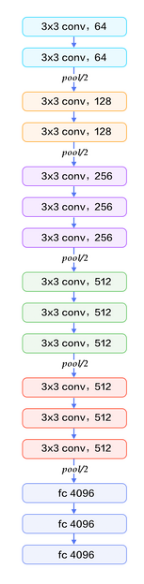

In [ ]:
######################################################################################################################
##### Plot the image given of required CNN structure as it was extremely hard to observe in markdown cell....... #####
######################################################################################################################

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 150

image = mpimg.imread(
    '/content/drive/MyDrive/Assignment3/CNN.png')
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# Step 2 implementation
from sklearn.metrics import f1_score
# Compute the function for determining accuracies
# def accuracy(output, target, topk=(1,)):
#     with torch.no_grad():
#         maxk = 1
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

#         correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

#         return correct_3.mul_(1.0 / batch_size)

# Compute the base class for training and testing process to be inherited
class Base(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        preds = torch.argmax(out, dim=1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')

        return {'val_loss': loss.detach(), 'val_acc_f1': f1}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_f1s = [x["val_acc_f1"] for x in outputs]
        epoch_f1 = np.mean(batch_f1s)
        return {'val_loss': epoch_loss.item(), 'val_acc_f1': epoch_f1}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc_f1: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc_f1']))
# Compute the required CNN model class


class CNNBase(Base):
    def __init__(self, num_classes=5):
        super().__init__(num_classes=5)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Compute the code of using pre=trained model
class SqueezeNetModel(Base):
    def __init__(self, num_classes):
        super().__init__(num_classes)  # Pass num_classes to the base class
        self.network = models.squeezenet1_1(pretrained=True)
        # Modify the final classifier layer
        self.network.classifier[1] = nn.Conv2d(
            in_channels=self.network.classifier[1].in_channels,
            out_channels=num_classes,
            kernel_size=(1, 1)
        )

    def forward(self, x):
        return self.network(x)

# Generate the relevant models
model1 = CNNBase(len(classes)).to(device)





**3. Train the model. (15 Points)**

* What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?

* What methods do you use for monitoring the training progress and performance of the model and why?

* What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?

### Answer:

* The chosen method of hyperparameters was based on some trial runs and checking the convergence of loss. Because of the complex model, then I adjusted the learning rate to a small value. The optimizer Adam was chosen because of the complex CNN model to ensure the efficiency. Since the time required for training each epoch was too long, I then reduce the epoch and enlarged the batch size.

* I will be using validation accuracy and validation loss to monitor the training progress using tqdm training visualisations. This is to check whether there is overfitting or not.

* The method for accuracy determination was determined by f1 score imported from sklearn for balancing between Precision and Recall.


In [ ]:
# Step 3 implementation
from tqdm import tqdm

# Compute the evaluate function for determining validation accuracy on testing data
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# Compute the function for training
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
# Evaluate the performance before training
history = [evaluate(model1, val_loader)]
history


[{'val_loss': 1.6105753183364868, 'val_acc_f1': 0.046120549410023096}]

In [ ]:
# Set some hyper-parameters and start training
print(test_size)
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0001
history += fit(num_epochs, lr, model1, train_loader, val_loader, opt_func)


263


100%|██████████| 148/148 [00:28<00:00,  5.28it/s]


Epoch [0], train_loss: 1.6099, val_loss: 1.6107, val_acc_f1: 0.0461


100%|██████████| 148/148 [00:28<00:00,  5.28it/s]


Epoch [1], train_loss: 1.5230, val_loss: 1.3993, val_acc_f1: 0.2731


100%|██████████| 148/148 [00:27<00:00,  5.32it/s]


Epoch [2], train_loss: 1.2776, val_loss: 1.1748, val_acc_f1: 0.4352


100%|██████████| 148/148 [00:27<00:00,  5.29it/s]


Epoch [3], train_loss: 1.0847, val_loss: 1.0278, val_acc_f1: 0.5658


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [4], train_loss: 1.0120, val_loss: 1.0412, val_acc_f1: 0.5329


100%|██████████| 148/148 [00:28<00:00,  5.26it/s]


Epoch [5], train_loss: 0.9392, val_loss: 0.8790, val_acc_f1: 0.6664


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [6], train_loss: 0.8874, val_loss: 0.8710, val_acc_f1: 0.6426


100%|██████████| 148/148 [00:27<00:00,  5.30it/s]


Epoch [7], train_loss: 0.8393, val_loss: 0.8608, val_acc_f1: 0.6577


100%|██████████| 148/148 [00:27<00:00,  5.39it/s]


Epoch [8], train_loss: 0.8062, val_loss: 0.7795, val_acc_f1: 0.7240


100%|██████████| 148/148 [00:27<00:00,  5.32it/s]


Epoch [9], train_loss: 0.7665, val_loss: 0.8053, val_acc_f1: 0.6869


100%|██████████| 148/148 [00:27<00:00,  5.31it/s]


Epoch [10], train_loss: 0.7200, val_loss: 0.7222, val_acc_f1: 0.7205


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [11], train_loss: 0.6917, val_loss: 0.7592, val_acc_f1: 0.7071


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [12], train_loss: 0.6672, val_loss: 0.7447, val_acc_f1: 0.7467


100%|██████████| 148/148 [00:28<00:00,  5.24it/s]


Epoch [13], train_loss: 0.6174, val_loss: 0.8005, val_acc_f1: 0.7394


100%|██████████| 148/148 [00:28<00:00,  5.27it/s]


Epoch [14], train_loss: 0.5913, val_loss: 0.7379, val_acc_f1: 0.7315


100%|██████████| 148/148 [00:29<00:00,  5.06it/s]


Epoch [15], train_loss: 0.5351, val_loss: 0.7180, val_acc_f1: 0.7095


100%|██████████| 148/148 [00:29<00:00,  5.06it/s]


Epoch [16], train_loss: 0.5230, val_loss: 0.7083, val_acc_f1: 0.7628


100%|██████████| 148/148 [00:28<00:00,  5.16it/s]


Epoch [17], train_loss: 0.4703, val_loss: 0.7200, val_acc_f1: 0.7495


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [18], train_loss: 0.4634, val_loss: 0.7383, val_acc_f1: 0.7491


100%|██████████| 148/148 [00:28<00:00,  5.28it/s]


Epoch [19], train_loss: 0.4020, val_loss: 0.8222, val_acc_f1: 0.7255


**4. Report the results. (10 points)**

* What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?

* What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?

* How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?

* What is the rough model complexity?

* Is the model's large size contributing to any challenges or constraints in its performance on the given dataset.


### Answer:

* Because the training process took way too much time and computational cost, I had no choice but to reduce the epoch number to 5 due to the complex model structure. Fortunately, the training was kind of acceptable.

* The final accuracy on testing set is 78.8% and the final training accuracy is 72.7%. The larger accuracy of testing set may indicate that there is no overfitting.

* From the confusion matrices plotted, the sunflower class was the most difficult to classify because of the most number of incorrect predictions.

* The model complexity was identified by determining the number of parameters printed in the coding cell below.

* The model is indeed too complex to efficiently compute. Although it seemed I did not get overfitted result, with more epochs, there would possibly be some overfitting patterns like testing accuracy showing below than final training accuracy.

In [ ]:
# Step 4 implementation

# Define some functinos to plot the result
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
def plot_accuracies(history):
    accuracies = [x['val_acc_f1'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Each Epoch')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss of Each Epoch')
    plt.show()


def compute_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return confusion_matrix(all_labels, all_preds)


def plot_confusion_matrix(cm, classes, name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('\nPredicted Label')
    plt.ylabel('\nTrue Label')
    plt.title(f'Confusion Matrix of {name}')
    plt.show()

def classification(dataloader, model):
    model.eval()
    all_labels = []
    all_preds = []
    misclassified_images = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return classification_report(all_labels, all_preds, target_names=classes,output_dict=True)



def model_complexity(model):
    print (f'Num of Parameters: {sum(p.numel() for p in model.parameters())}')


{'val_loss': 0.6692311763763428, 'val_acc_f1': 0.7877639987780919}


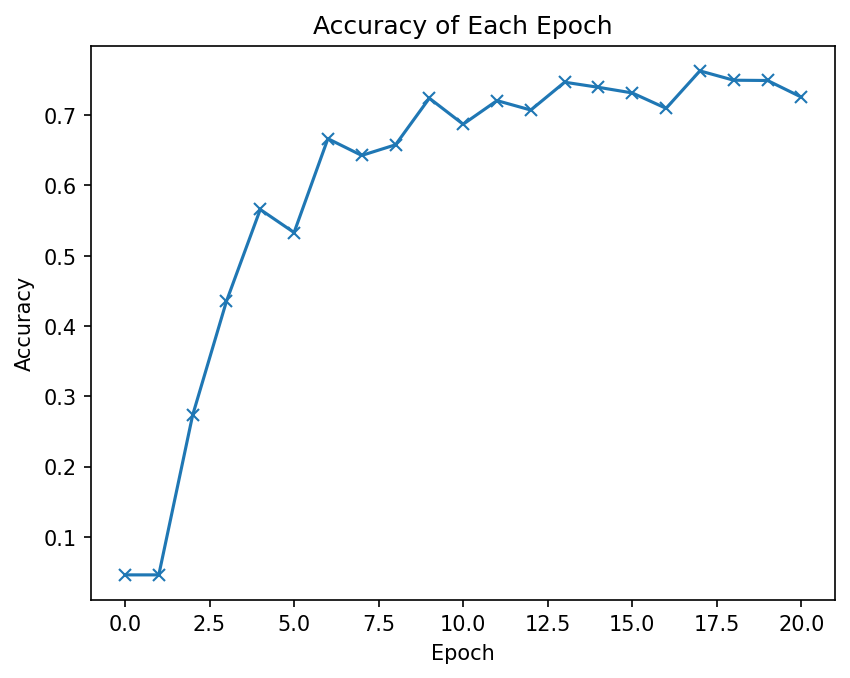

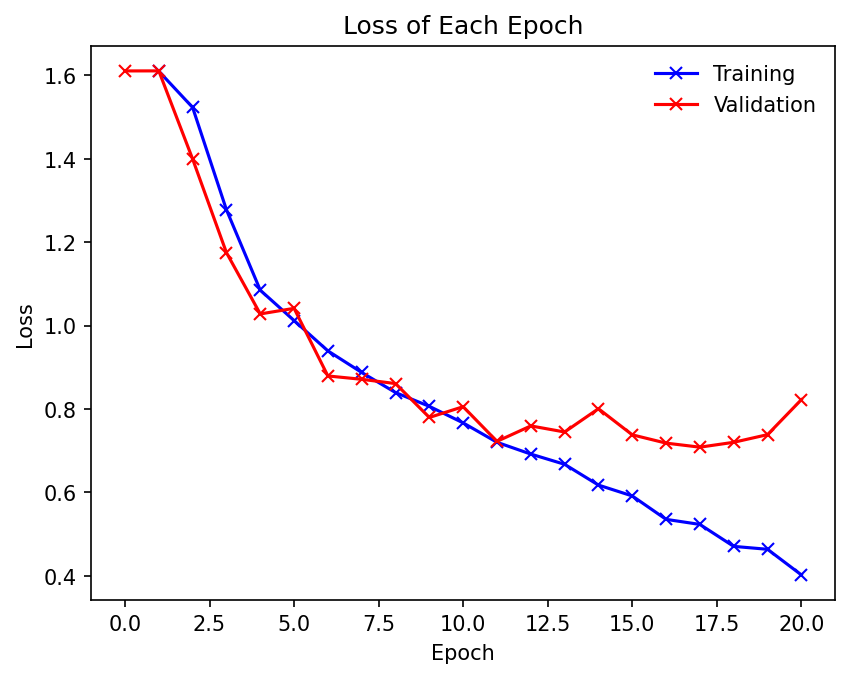

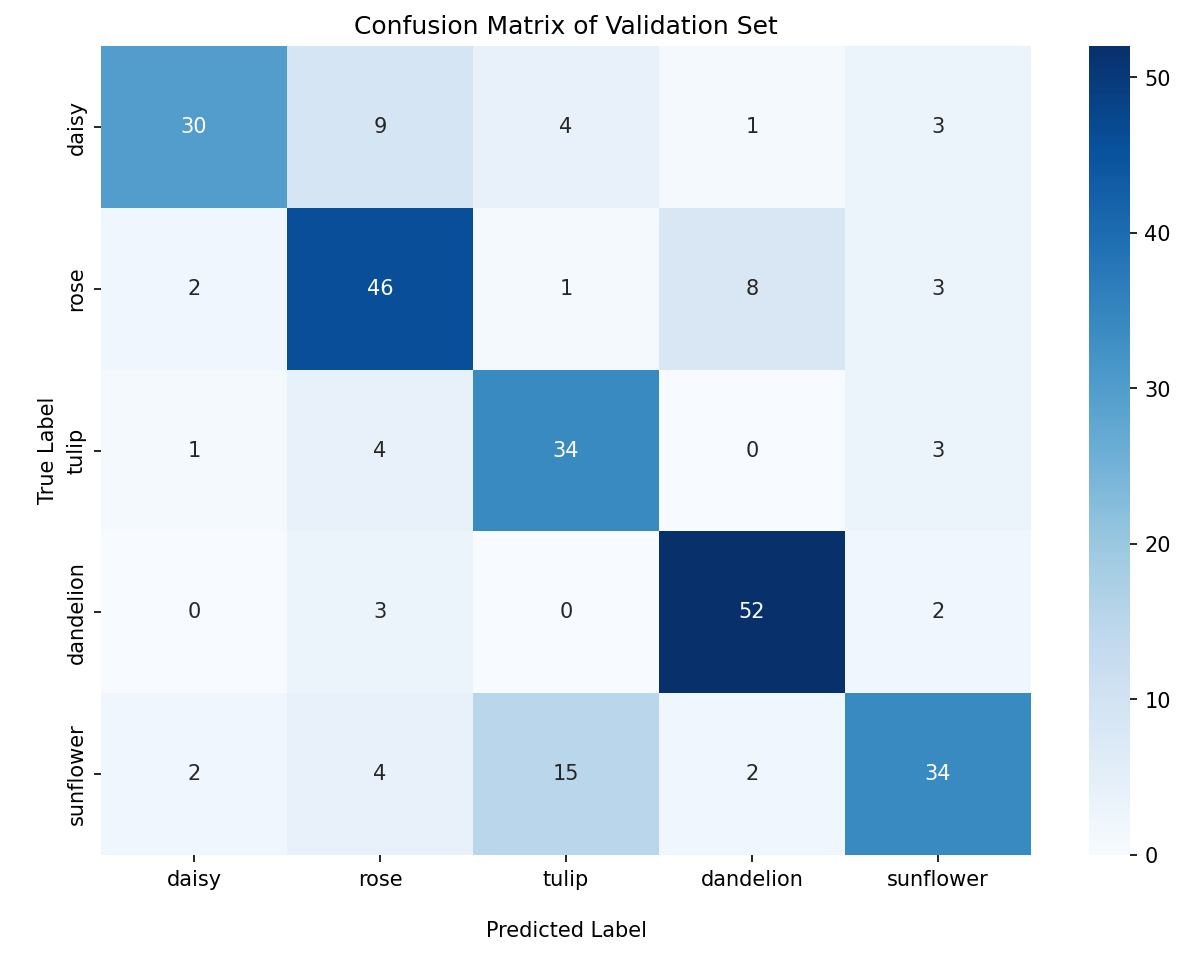

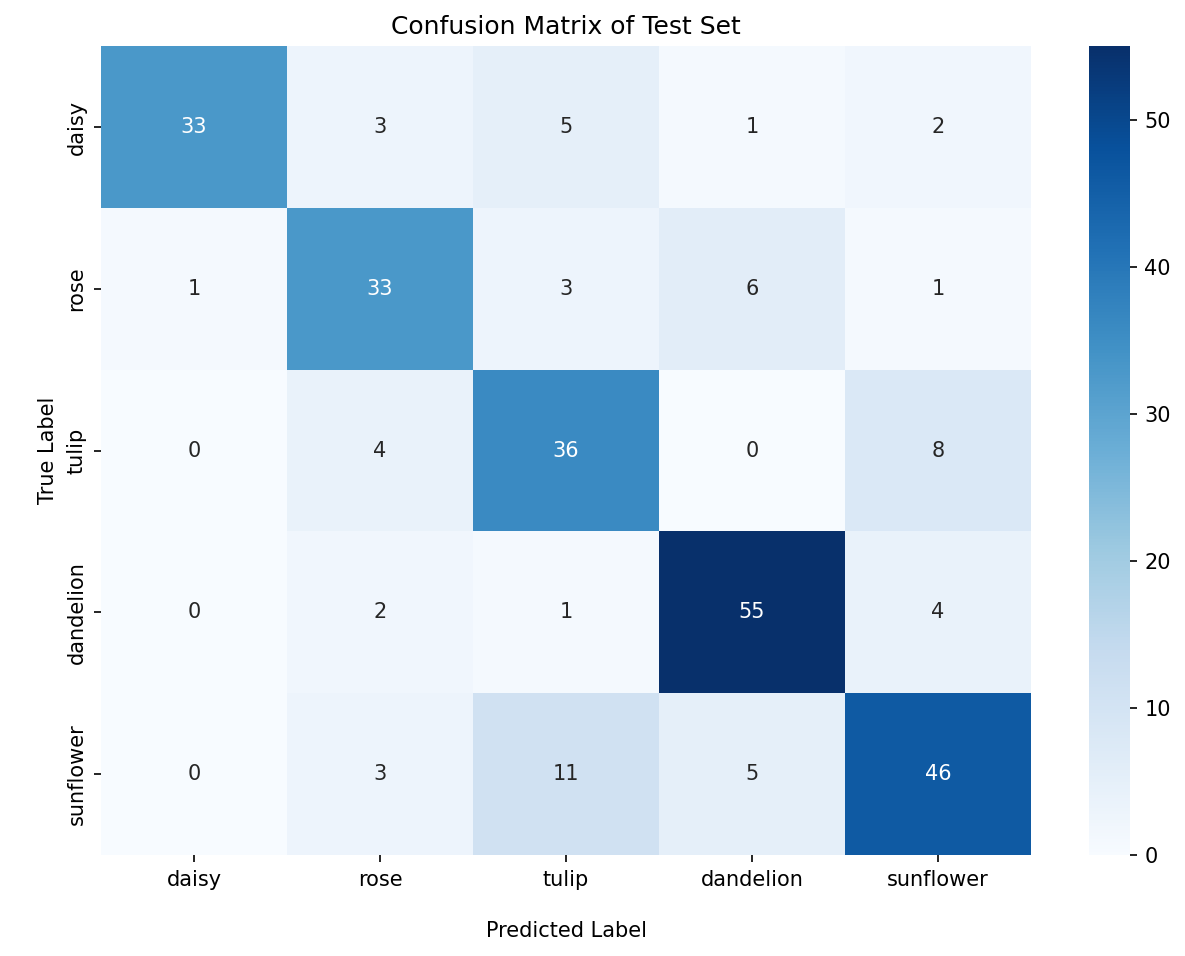

Num of Parameters: 134281029
daisy:
	Precision: 0.8750
	Recall: 0.5957
	F1-score: 0.7089
rose:
	Precision: 0.7500
	Recall: 0.7500
	F1-score: 0.7500
tulip:
	Precision: 0.5893
	Recall: 0.7857
	F1-score: 0.6735
dandelion:
	Precision: 0.7647
	Recall: 0.9123
	F1-score: 0.8320
sunflower:
	Precision: 0.7447
	Recall: 0.6140
	F1-score: 0.6731


In [ ]:
# Result visualisation
print(evaluate(model1, test_loader))
plot_accuracies(history)
plot_losses(history)
cm = compute_confusion_matrix(model1, val_loader)
plot_confusion_matrix(cm, classes, 'Validation Set')
cm_test = compute_confusion_matrix(model1, test_loader)
plot_confusion_matrix(cm_test, classes, 'Test Set')
model_complexity(CNNBase())

rep_base = classification(val_loader, model1)
for cl, metrics in rep_base.items():
    if cl in classes:
        print(
            f"{cl}:\n\tPrecision: {metrics['precision']:.4f}\n\tRecall: {metrics['recall']:.4f}\n\tF1-score: {metrics['f1-score']:.4f}")


**5. Test the model by giving it a picture taken by your own phone camera. (10 points)**

* How can the accuracy of the model on the picture taken by your own phone camera be evaluated?

* What can be done if the model does not perform well on the picture taken by your own phone camera?


The accuracy was computed in cell below.

The model successfully identified the sunflower despite of the low testing accuracy obtained before.

daisy: Probability = 0.0067
dandelion: Probability = 0.0854
rose: Probability = 0.0005
sunflower: Probability = 0.8027
tulip: Probability = 0.1047
The predicted class for the new image is "sunflowers".


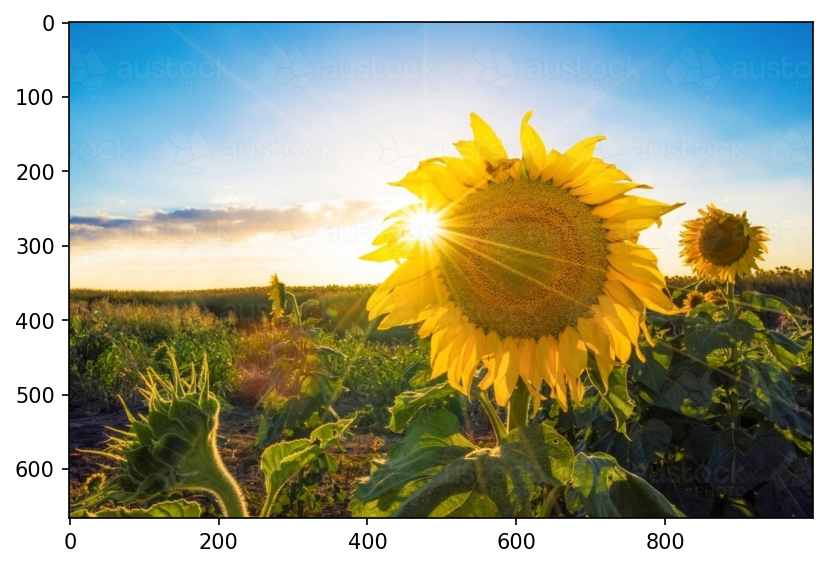

In [ ]:
# Step 5 implementation
from PIL import Image

class_names = dataset.classes
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Define some functions for predicting the class of new image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image


def predict_image(model, image_path, transform, device='cuda'):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    image = image.to(device)

    model = model.to(device)

    model.eval()

    with torch.no_grad():
        output = model(image)
        softmax = torch.nn.Softmax(dim=1)
        probabilities = softmax(output)
        for i, prob in enumerate(probabilities[0]):
            print(f"{dataset.classes[i]}: Probability = {prob.item():.4f}")
        _, predicted = torch.max(output, 1)

    class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    return class_names[predicted.item()]

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.488), (0.2172))
])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_add = '/content/drive/MyDrive/Assignment3/Sunflower Phone.jpg'
predicted_class = predict_image(model1, image_add, test_transform, device)
print(f'The predicted class for the new image is "{predicted_class}".')

img = Image.open(image_add)
plt.imshow(img)
plt.show()

**6. Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization. (20 points)**


* Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?

* How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?

* What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?

### Answer:

* L2 regularization basically did not contribute anything to improve the performance. On the contrary, the model went to convergence even much earlier, which in turn, caused the model unable to predict anything. When I manually adjusted the weight decay to an extremely small value, the model behaved basically the same as the baseline model.
On the other hand, batch normalisation increased the accuracy with a noticeable amount. The accuracy went to 79.1% with final training accuracy of 83.7%, indicating that overfitting might occur. The convergence, though, did not reach soon after several epochs. The time for training was longer for batch normalisation case than that for L2 regularisation. This was because of the larger architecture with added batchnorm layers.

* The weights in L2 regularisation generally decreased compared to those in baseline model. This indicated that the model became more simple leading to theoretically less computational cost.

* In a nutshell, the L1 and L2 regularization reduced the complexity of model while maintaining a similar pattern of performance. The batch normalisation model gave a better performance but the trade-off is to increase the complexity.



In [ ]:
# Step 6 implementation
def fitl2(epochs, lr, model, train_loader, val_loader, weight_decay):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
# L2 regularization
model_l2 = CNNBase(num_classes=5).to(device)

history_l2 = [evaluate(model_l2, val_loader)]
history_l2 += fitl2(10,lr, model_l2, train_loader, val_loader, weight_decay=0.0000001)


100%|██████████| 148/148 [00:28<00:00,  5.19it/s]


Epoch [0], train_loss: 1.5473, val_loss: 1.4631, val_acc_f1: 0.1853


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [1], train_loss: 1.2882, val_loss: 1.2245, val_acc_f1: 0.4484


100%|██████████| 148/148 [00:28<00:00,  5.26it/s]


Epoch [2], train_loss: 1.1422, val_loss: 1.1389, val_acc_f1: 0.4873


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [3], train_loss: 1.0794, val_loss: 1.1070, val_acc_f1: 0.5640


100%|██████████| 148/148 [00:27<00:00,  5.31it/s]


Epoch [4], train_loss: 1.0244, val_loss: 1.0221, val_acc_f1: 0.6473


100%|██████████| 148/148 [00:27<00:00,  5.32it/s]


Epoch [5], train_loss: 0.9552, val_loss: 0.9910, val_acc_f1: 0.6543


100%|██████████| 148/148 [00:27<00:00,  5.41it/s]


Epoch [6], train_loss: 0.9069, val_loss: 0.9105, val_acc_f1: 0.6891


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [7], train_loss: 0.8619, val_loss: 0.8729, val_acc_f1: 0.6517


100%|██████████| 148/148 [00:27<00:00,  5.29it/s]


Epoch [8], train_loss: 0.8267, val_loss: 0.8725, val_acc_f1: 0.6910


100%|██████████| 148/148 [00:27<00:00,  5.36it/s]


Epoch [9], train_loss: 0.7766, val_loss: 0.8143, val_acc_f1: 0.6731


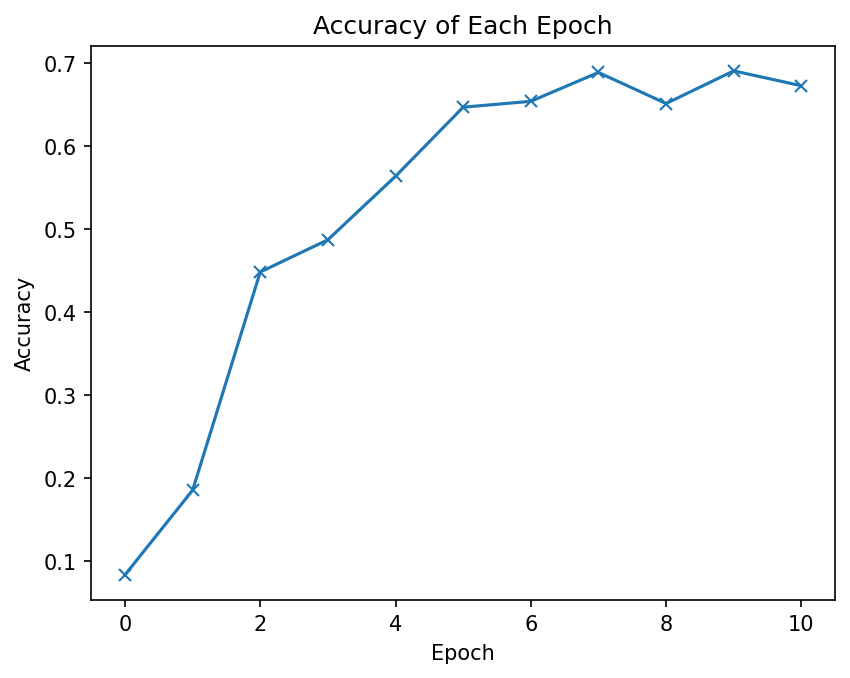

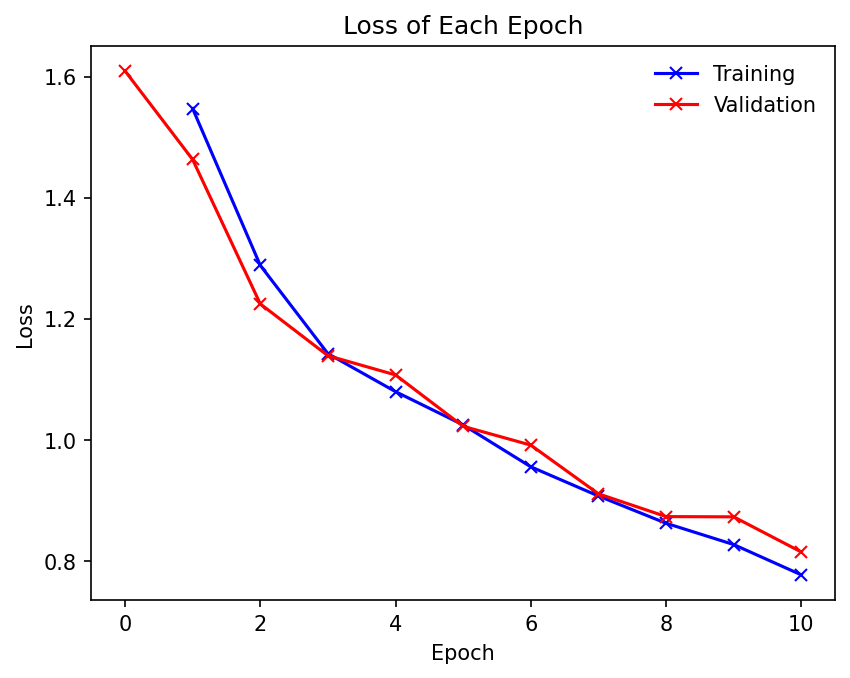

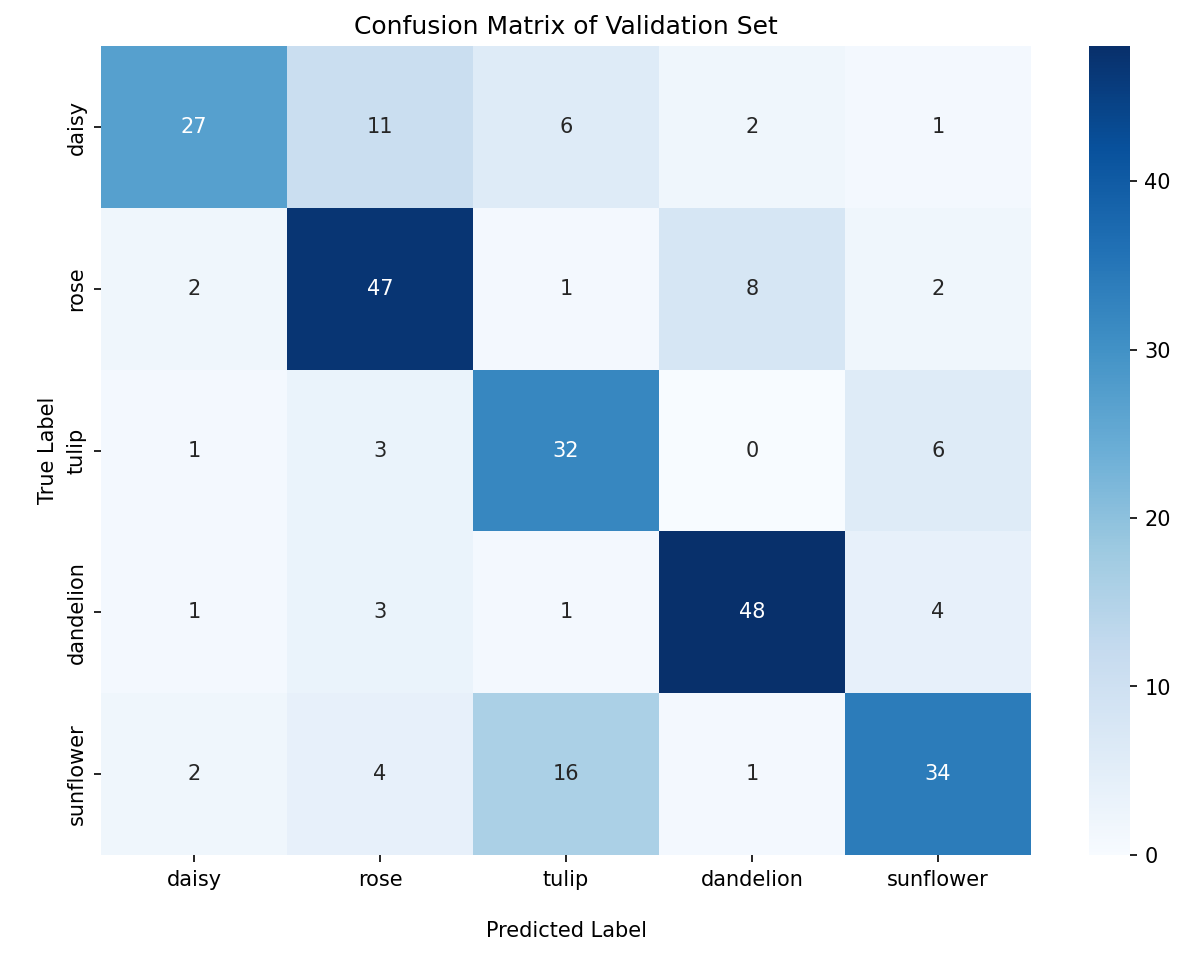

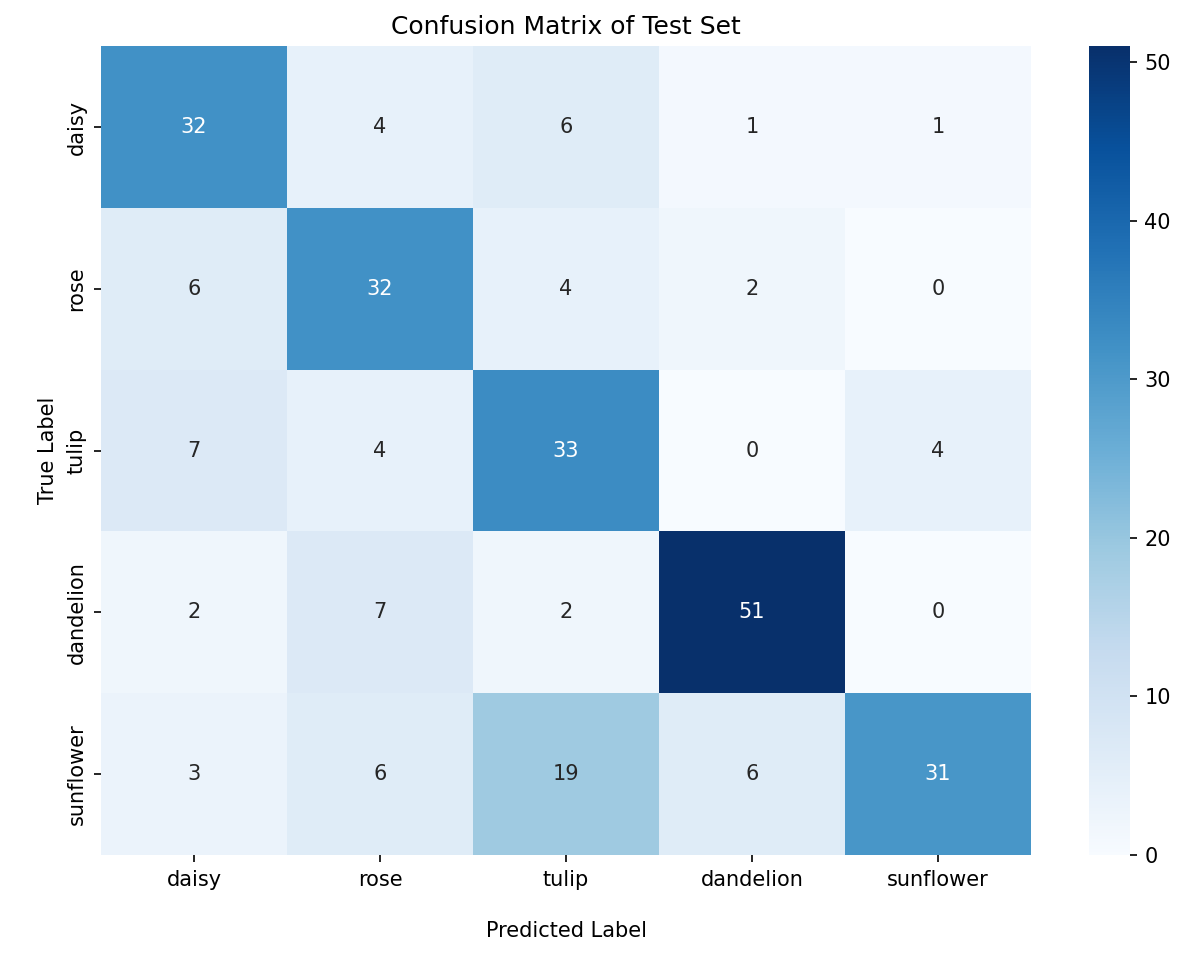

Num of Parameters: 134281029
Baseline Model:

{'features.0.weight': (0.0014, 0.1115), 'features.2.weight': (-0.0024, 0.0254), 'features.5.weight': (-0.0021, 0.0253), 'features.7.weight': (-0.002, 0.0188), 'features.10.weight': (-0.0021, 0.0188), 'features.12.weight': (-0.0019, 0.0139), 'features.14.weight': (-0.0016, 0.0133), 'features.17.weight': (-0.002, 0.0134), 'features.19.weight': (-0.0019, 0.0102), 'features.21.weight': (-0.0018, 0.0094), 'features.24.weight': (-0.0009, 0.0098), 'features.26.weight': (-0.0021, 0.0105), 'features.28.weight': (-0.0021, 0.0105), 'classifier.0.weight': (-0.0007, 0.0059), 'classifier.2.weight': (-0.0001, 0.01), 'classifier.4.weight': (-0.0016, 0.0116)}

L2 Regularization:

{'features.0.weight': (-0.0037, 0.1103), 'features.2.weight': (-0.0015, 0.0244), 'features.5.weight': (-0.0009, 0.0243), 'features.7.weight': (-0.0006, 0.0173), 'features.10.weight': (-0.0006, 0.0163), 'features.12.weight': (-0.0006, 0.0107), 'features.14.weight': (-0.0008, 0.0099)

In [ ]:

def weights(model):
    weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            mean = round(param.data.mean().item(), 4)
            std = round(param.data.std().item(), 4)
            weights[name] = (mean, std)
    print (weights)



# Result Visualisation
plot_accuracies(history_l2)
plot_losses(history_l2)
evaluate(model_l2, test_loader)
cm_l2 = compute_confusion_matrix(model1, val_loader)
plot_confusion_matrix(cm_l2, classes, 'Validation Set')
cm_test_l2 = compute_confusion_matrix(model_l2, test_loader)
plot_confusion_matrix(cm_test_l2, classes, 'Test Set')
model_complexity(CNNBase())
print(f"Baseline Model:\n")
weights(model1)
print(f"\nL2 Regularization:\n")
weights(model_l2)

In [ ]:
# Batch Normalisation

class CNNBaseWithBatchNorm(CNNBase):
    def __init__(self, num_classes):
        super(CNNBaseWithBatchNorm, self).__init__(num_classes)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )


model_bn= CNNBaseWithBatchNorm(num_classes=5).to(device)
history_bn = [evaluate(model_bn, val_loader)]
history_bn += fit(20, lr, model_bn, train_loader, val_loader, opt_func)


100%|██████████| 148/148 [00:28<00:00,  5.27it/s]


Epoch [0], train_loss: 1.3205, val_loss: 1.0894, val_acc_f1: 0.5470


100%|██████████| 148/148 [00:28<00:00,  5.18it/s]


Epoch [1], train_loss: 1.0641, val_loss: 1.1717, val_acc_f1: 0.5434


100%|██████████| 148/148 [00:28<00:00,  5.27it/s]


Epoch [2], train_loss: 0.9377, val_loss: 0.9456, val_acc_f1: 0.6514


100%|██████████| 148/148 [00:28<00:00,  5.23it/s]


Epoch [3], train_loss: 0.8505, val_loss: 0.8308, val_acc_f1: 0.6832


100%|██████████| 148/148 [00:28<00:00,  5.25it/s]


Epoch [4], train_loss: 0.7773, val_loss: 0.9801, val_acc_f1: 0.6710


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [5], train_loss: 0.7403, val_loss: 0.7742, val_acc_f1: 0.7352


100%|██████████| 148/148 [00:28<00:00,  5.26it/s]


Epoch [6], train_loss: 0.6951, val_loss: 0.7216, val_acc_f1: 0.7257


100%|██████████| 148/148 [00:28<00:00,  5.19it/s]


Epoch [7], train_loss: 0.6536, val_loss: 0.7379, val_acc_f1: 0.7222


100%|██████████| 148/148 [00:28<00:00,  5.23it/s]


Epoch [8], train_loss: 0.6206, val_loss: 0.6672, val_acc_f1: 0.7337


100%|██████████| 148/148 [00:28<00:00,  5.18it/s]


Epoch [9], train_loss: 0.5966, val_loss: 0.7640, val_acc_f1: 0.7768


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [10], train_loss: 0.5638, val_loss: 0.6367, val_acc_f1: 0.7812


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [11], train_loss: 0.5385, val_loss: 0.6175, val_acc_f1: 0.7706


100%|██████████| 148/148 [00:27<00:00,  5.30it/s]


Epoch [12], train_loss: 0.5269, val_loss: 0.5620, val_acc_f1: 0.8006


100%|██████████| 148/148 [00:28<00:00,  5.27it/s]


Epoch [13], train_loss: 0.4930, val_loss: 0.7150, val_acc_f1: 0.7761


100%|██████████| 148/148 [00:28<00:00,  5.24it/s]


Epoch [14], train_loss: 0.4546, val_loss: 0.5579, val_acc_f1: 0.8021


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [15], train_loss: 0.4612, val_loss: 0.5866, val_acc_f1: 0.8000


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [16], train_loss: 0.4446, val_loss: 0.5017, val_acc_f1: 0.8392


100%|██████████| 148/148 [00:28<00:00,  5.23it/s]


Epoch [17], train_loss: 0.4014, val_loss: 0.4862, val_acc_f1: 0.8431


100%|██████████| 148/148 [00:28<00:00,  5.25it/s]


Epoch [18], train_loss: 0.3919, val_loss: 0.6432, val_acc_f1: 0.7950


100%|██████████| 148/148 [00:28<00:00,  5.23it/s]


Epoch [19], train_loss: 0.3568, val_loss: 0.5025, val_acc_f1: 0.8366


{'val_loss': 0.533855140209198, 'val_acc_f1': 0.7911828273325306}


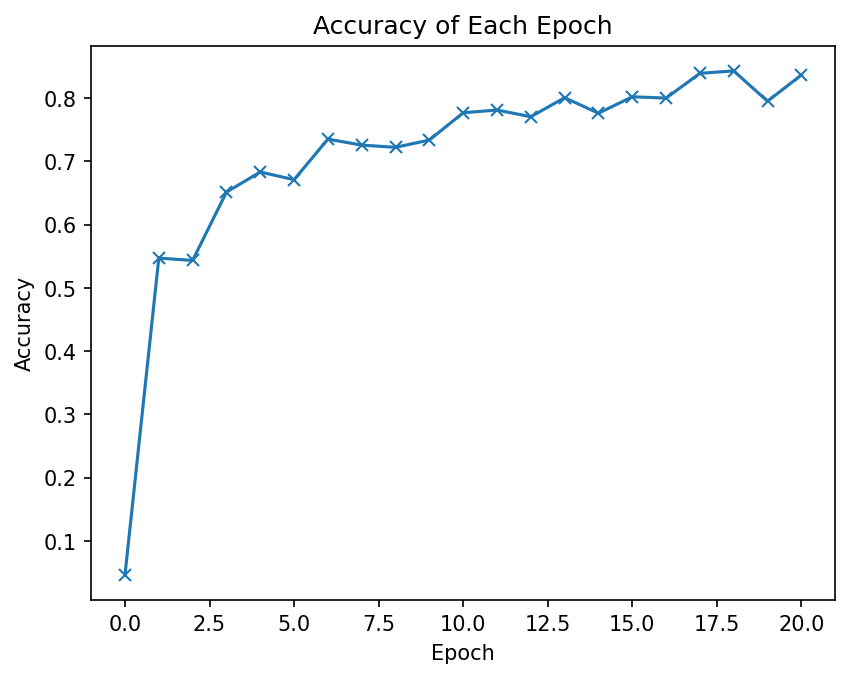

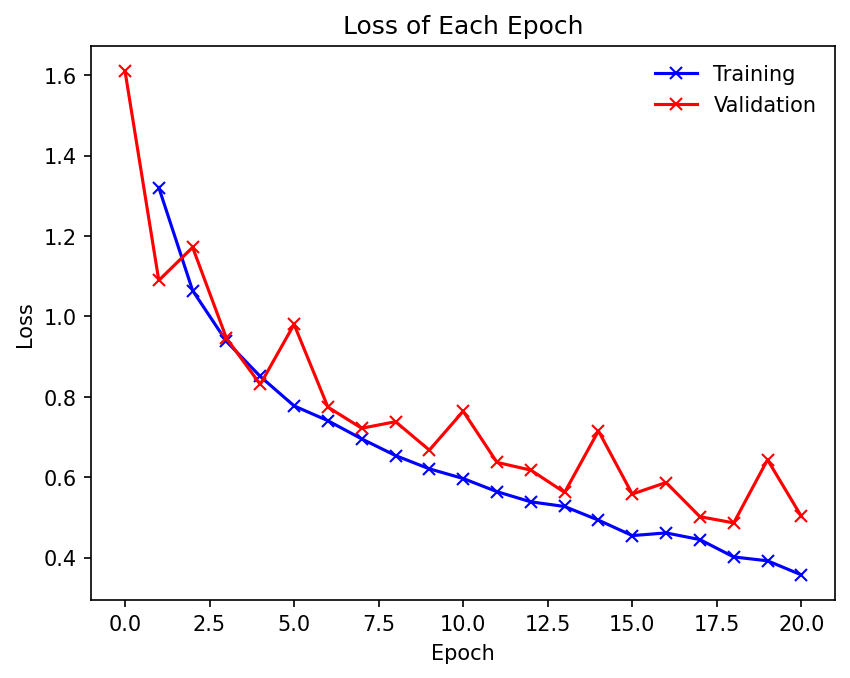

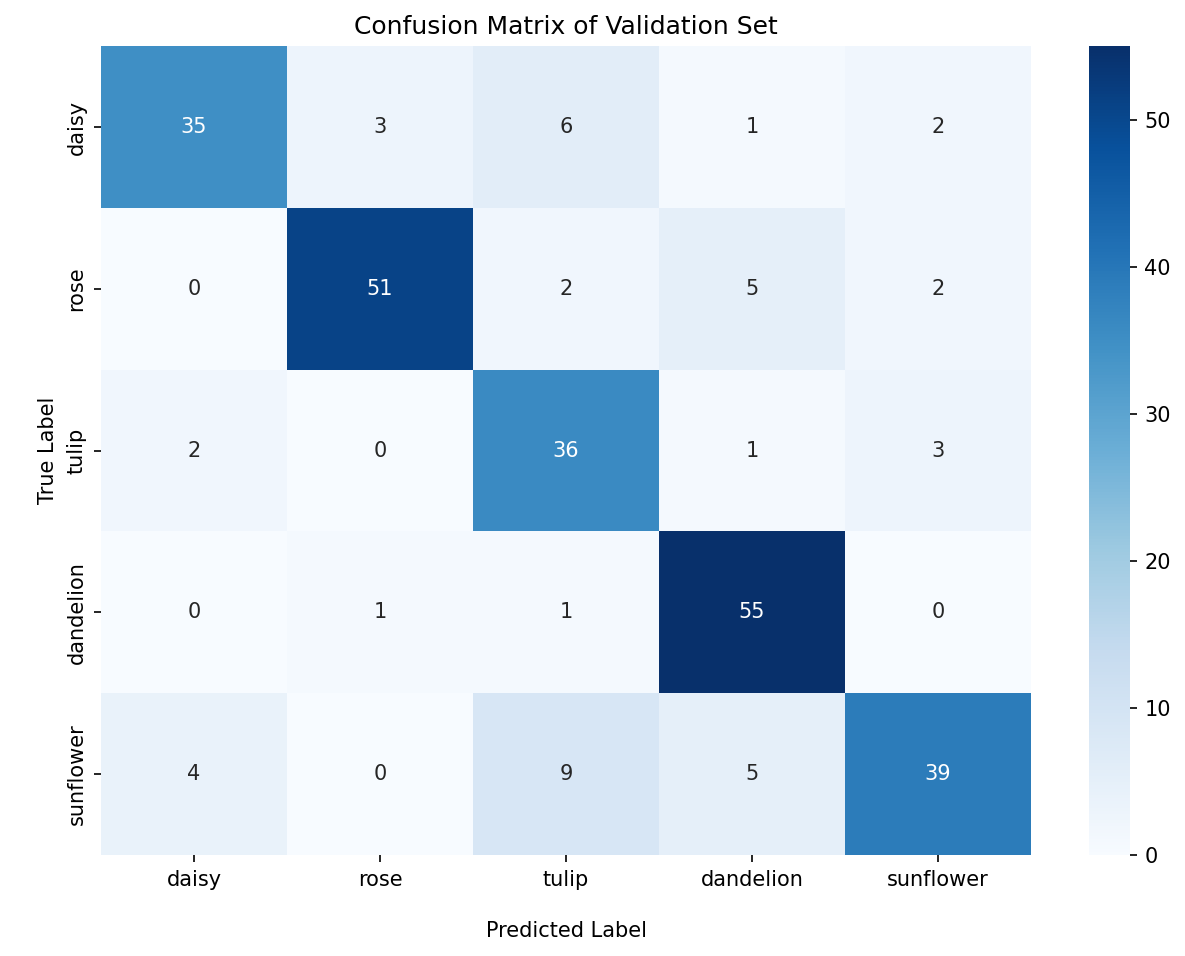

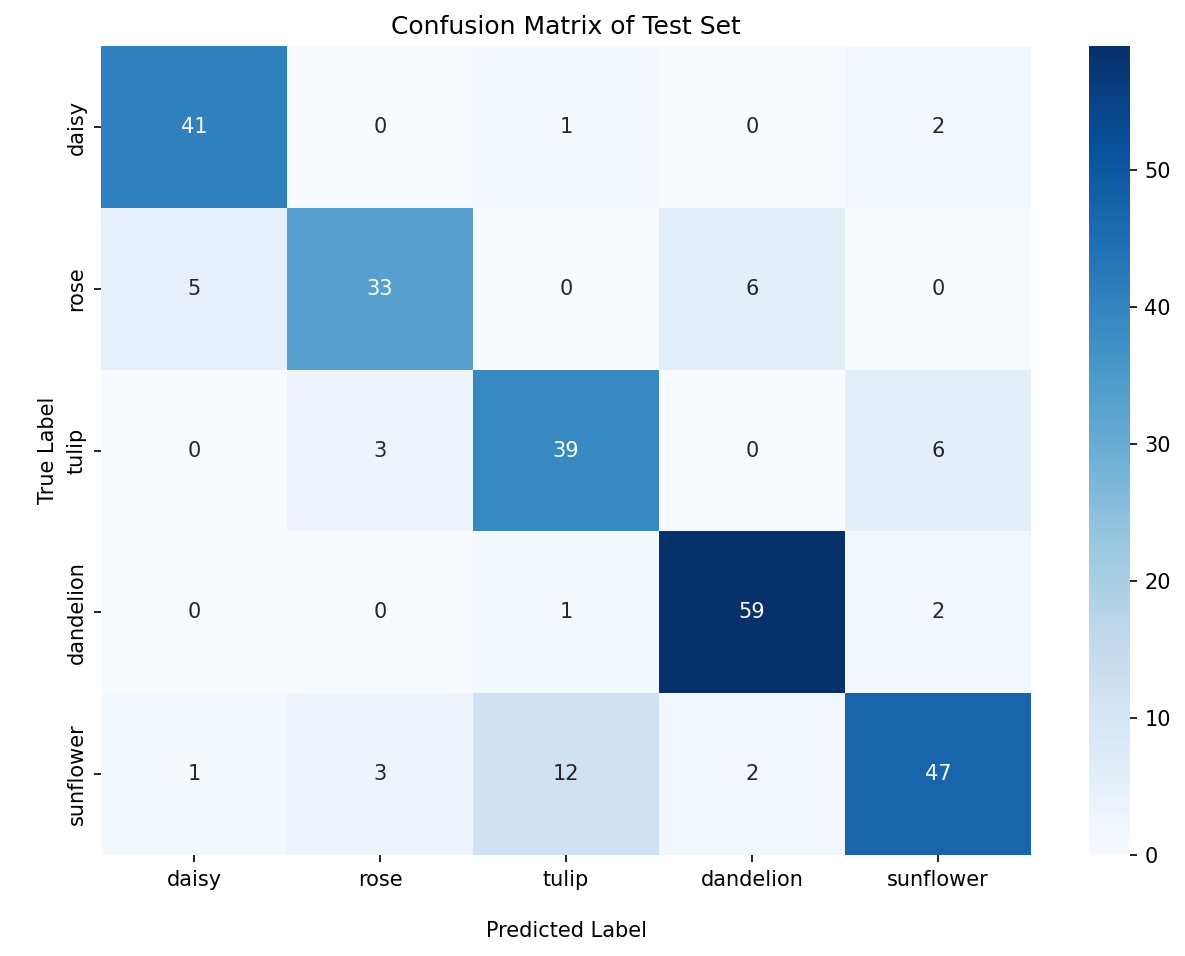

Num of Parameters: 134289477


In [ ]:
# Result Visualisation
print(evaluate(model_bn, test_loader))
plot_accuracies(history_bn)
plot_losses(history_bn)
cm__bn = compute_confusion_matrix(model_bn, val_loader)
plot_confusion_matrix(cm__bn, classes, 'Validation Set')
cm_test_bn = compute_confusion_matrix(model_bn, test_loader)
plot_confusion_matrix(cm_test_bn, classes, 'Test Set')
model_complexity(CNNBaseWithBatchNorm(num_classes=5))


**7. Improve the accuracy by trying something extra. (20 points)**

* By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved?

* Modify the given model architecture to improve the accuracy over the baseline? You can modify the model architecture by adding or removing layers, changing the number of filters, or adding skip connections.


* Use transfer learning to fine-tune an existing pre-trained model to improve accuracy?  What approach will you use for transfer learning: feature extraction or fine-tuning and why?



### Answer:
* Too much data augmentation would have adverse effect on performance as the training dataset would be over-processed to get noised. Batch normalisation had been proved to be effective in terms of improving accuracy with codes above. But the predictions are sunflowers are still the hardest one.

* I removed 1 layer and added dropout to the baseline model. The testing accuracy was 77.1% with final training accuracy 77.9%. There was no obvious overfitting. The general performance was not improved.

* By using pre-trained models, the accuracy can be hugely improved. I used feature-extraction approach with usage of pre-trained squeezeNet, a simplified version of ResNet series, with modifications of output layer. I have already included data augmentations at the beginning of the notebook. Theoretically, data augmentations, normalisations, and other preprocess methods would increase the accuracy, however, by mannually checking the dataset, I found that there were too many images having a person or other irrelevant objects taking too much space of the entire image, possibly influencing training. But after the test of applying pre-trained model, such effect was largely reduced and a tremendous improvement in both accuracy and effiency were achieved. Hence, in order not to affect the original pre-trained model with these noisy images, I used feature-extraction. The testing accuracy reached 93.0% with final training of 90.4%, indicating not only no overfitting, but also great performances on testing accuracy.

In [ ]:
# Step 7 implementation
# Modify the base class
class CNNModified(Base):
    def __init__(self, num_classes=5):
        super().__init__(num_classes=5)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Added Dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Added Dropout
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model_mo= CNNModified(num_classes=5).to(device)
history_mo = [evaluate(model_mo, val_loader)]
history_mo += fit(20, lr, model_mo, train_loader, val_loader, opt_func)

100%|██████████| 148/148 [00:27<00:00,  5.31it/s]


Epoch [0], train_loss: 1.4662, val_loss: 1.2947, val_acc_f1: 0.2983


100%|██████████| 148/148 [00:27<00:00,  5.37it/s]


Epoch [1], train_loss: 1.1575, val_loss: 1.1447, val_acc_f1: 0.4431


100%|██████████| 148/148 [00:27<00:00,  5.29it/s]


Epoch [2], train_loss: 1.0809, val_loss: 1.0436, val_acc_f1: 0.5767


100%|██████████| 148/148 [00:27<00:00,  5.35it/s]


Epoch [3], train_loss: 1.0041, val_loss: 0.9867, val_acc_f1: 0.5745


100%|██████████| 148/148 [00:27<00:00,  5.31it/s]


Epoch [4], train_loss: 0.9449, val_loss: 0.9032, val_acc_f1: 0.6367


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [5], train_loss: 0.8832, val_loss: 0.8804, val_acc_f1: 0.6597


100%|██████████| 148/148 [00:27<00:00,  5.32it/s]


Epoch [6], train_loss: 0.7967, val_loss: 0.8334, val_acc_f1: 0.6648


100%|██████████| 148/148 [00:27<00:00,  5.36it/s]


Epoch [7], train_loss: 0.7492, val_loss: 0.8546, val_acc_f1: 0.6896


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [8], train_loss: 0.7170, val_loss: 0.7971, val_acc_f1: 0.6847


100%|██████████| 148/148 [00:27<00:00,  5.30it/s]


Epoch [9], train_loss: 0.6765, val_loss: 0.7775, val_acc_f1: 0.7072


100%|██████████| 148/148 [00:27<00:00,  5.35it/s]


Epoch [10], train_loss: 0.6237, val_loss: 0.7919, val_acc_f1: 0.7381


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [11], train_loss: 0.5791, val_loss: 0.8145, val_acc_f1: 0.6705


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [12], train_loss: 0.5390, val_loss: 0.7098, val_acc_f1: 0.7143


100%|██████████| 148/148 [00:27<00:00,  5.40it/s]


Epoch [13], train_loss: 0.4978, val_loss: 0.7479, val_acc_f1: 0.7444


100%|██████████| 148/148 [00:27<00:00,  5.34it/s]


Epoch [14], train_loss: 0.4549, val_loss: 0.7251, val_acc_f1: 0.7610


100%|██████████| 148/148 [00:27<00:00,  5.31it/s]


Epoch [15], train_loss: 0.4062, val_loss: 0.8306, val_acc_f1: 0.7219


100%|██████████| 148/148 [00:27<00:00,  5.37it/s]


Epoch [16], train_loss: 0.3818, val_loss: 0.7089, val_acc_f1: 0.7739


100%|██████████| 148/148 [00:27<00:00,  5.33it/s]


Epoch [17], train_loss: 0.3557, val_loss: 0.7679, val_acc_f1: 0.7820


100%|██████████| 148/148 [00:27<00:00,  5.30it/s]


Epoch [18], train_loss: 0.2973, val_loss: 0.7694, val_acc_f1: 0.7507


100%|██████████| 148/148 [00:27<00:00,  5.40it/s]


Epoch [19], train_loss: 0.2872, val_loss: 0.7567, val_acc_f1: 0.7791


{'val_loss': 0.6804969906806946, 'val_acc_f1': 0.7707094370842437}


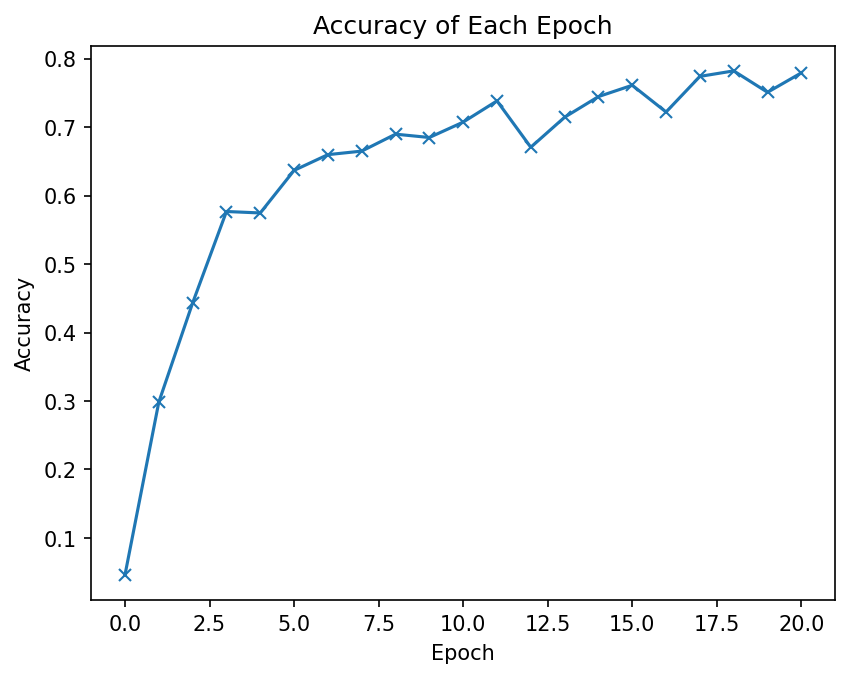

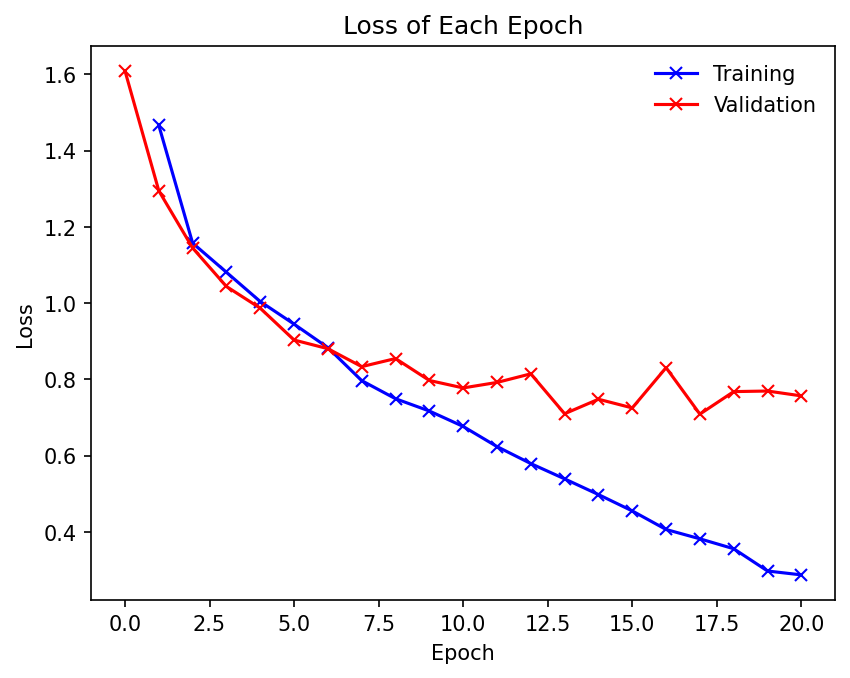

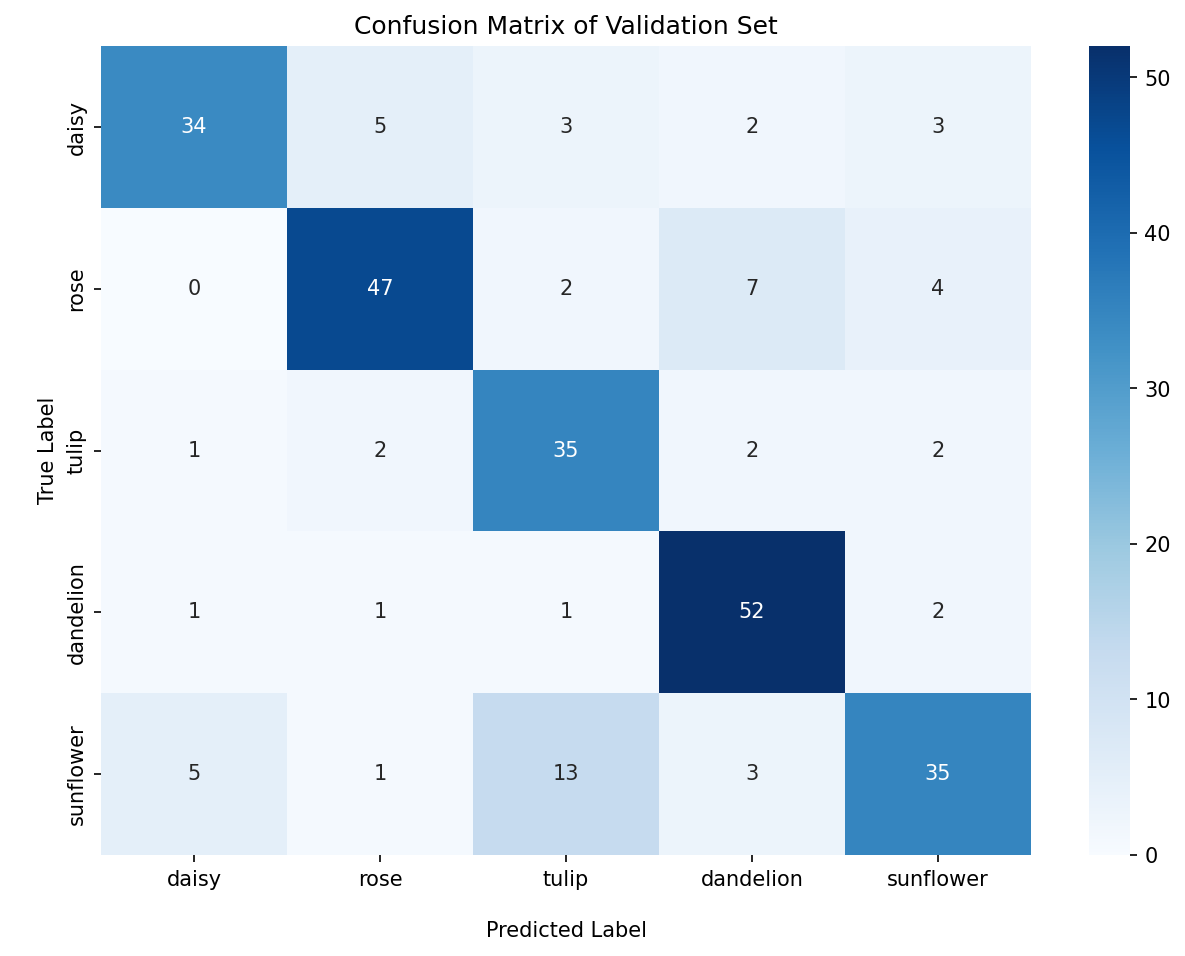

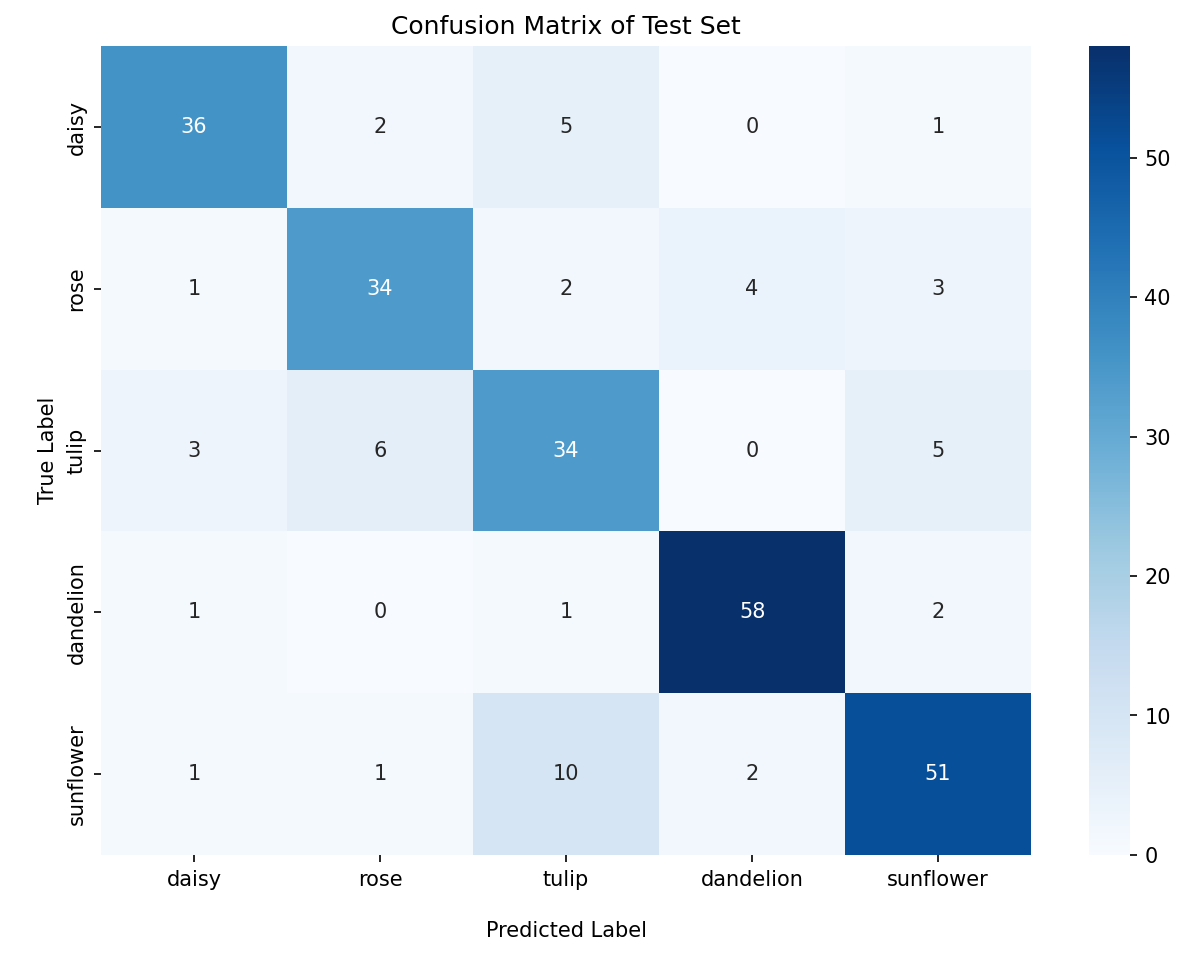

Num of Parameters: 435482949


In [ ]:
# Result Visualisation
print(evaluate(model_mo, test_loader))
plot_accuracies(history_mo)
plot_losses(history_mo)
cm__mo = compute_confusion_matrix(model_mo, val_loader)
plot_confusion_matrix(cm__mo, classes, 'Validation Set')
cm_test_mo = compute_confusion_matrix(model_mo, test_loader)
plot_confusion_matrix(cm_test_mo, classes, 'Test Set')
model_complexity(CNNModified(num_classes=5))

In [ ]:

# Try SqueezeNet pre-trained model
modelsq = SqueezeNetModel(num_classes=5).to(device)
print(test_size)
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0005


historysq=[]

historysq += fit(20, lr, modelsq, train_loader, val_loader, opt_func)



Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 11.5MB/s]


263


100%|██████████| 148/148 [00:28<00:00,  5.11it/s]


Epoch [0], train_loss: 0.9892, val_loss: 1.0352, val_acc_f1: 0.5189


100%|██████████| 148/148 [00:28<00:00,  5.17it/s]


Epoch [1], train_loss: 0.6673, val_loss: 0.8358, val_acc_f1: 0.6244


100%|██████████| 148/148 [00:28<00:00,  5.17it/s]


Epoch [2], train_loss: 0.5573, val_loss: 0.4899, val_acc_f1: 0.8204


100%|██████████| 148/148 [00:28<00:00,  5.17it/s]


Epoch [3], train_loss: 0.4499, val_loss: 0.5022, val_acc_f1: 0.8185


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [4], train_loss: 0.4501, val_loss: 0.4418, val_acc_f1: 0.8320


100%|██████████| 148/148 [00:28<00:00,  5.26it/s]


Epoch [5], train_loss: 0.3526, val_loss: 0.4927, val_acc_f1: 0.7886


100%|██████████| 148/148 [00:28<00:00,  5.28it/s]


Epoch [6], train_loss: 0.3440, val_loss: 0.4068, val_acc_f1: 0.8781


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [7], train_loss: 0.3164, val_loss: 0.6042, val_acc_f1: 0.8053


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [8], train_loss: 0.3203, val_loss: 0.4369, val_acc_f1: 0.8177


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [9], train_loss: 0.2886, val_loss: 0.3270, val_acc_f1: 0.8898


100%|██████████| 148/148 [00:28<00:00,  5.22it/s]


Epoch [10], train_loss: 0.2924, val_loss: 0.3327, val_acc_f1: 0.8745


100%|██████████| 148/148 [00:28<00:00,  5.25it/s]


Epoch [11], train_loss: 0.2484, val_loss: 0.3210, val_acc_f1: 0.8963


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [12], train_loss: 0.2352, val_loss: 0.4246, val_acc_f1: 0.8499


100%|██████████| 148/148 [00:28<00:00,  5.19it/s]


Epoch [13], train_loss: 0.2389, val_loss: 0.3891, val_acc_f1: 0.8687


100%|██████████| 148/148 [00:28<00:00,  5.24it/s]


Epoch [14], train_loss: 0.1988, val_loss: 0.2755, val_acc_f1: 0.9017


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [15], train_loss: 0.2093, val_loss: 0.3220, val_acc_f1: 0.8719


100%|██████████| 148/148 [00:28<00:00,  5.21it/s]


Epoch [16], train_loss: 0.2277, val_loss: 0.3051, val_acc_f1: 0.8890


100%|██████████| 148/148 [00:28<00:00,  5.23it/s]


Epoch [17], train_loss: 0.1860, val_loss: 0.2776, val_acc_f1: 0.8973


100%|██████████| 148/148 [00:28<00:00,  5.24it/s]


Epoch [18], train_loss: 0.1711, val_loss: 0.4267, val_acc_f1: 0.8563


100%|██████████| 148/148 [00:28<00:00,  5.19it/s]


Epoch [19], train_loss: 0.1801, val_loss: 0.3197, val_acc_f1: 0.9041


{'val_loss': 0.200153648853302, 'val_acc_f1': 0.9302718211572378}


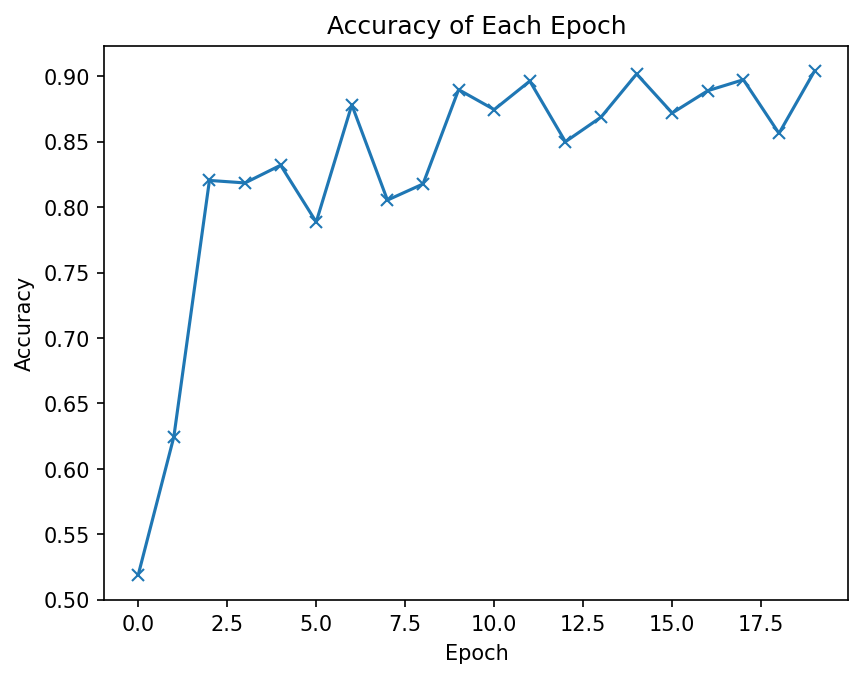

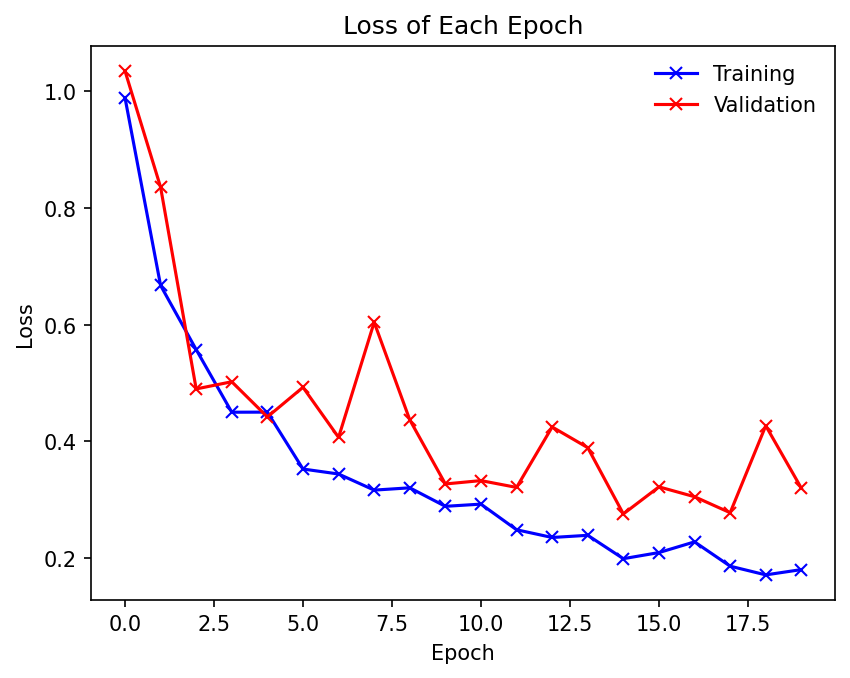

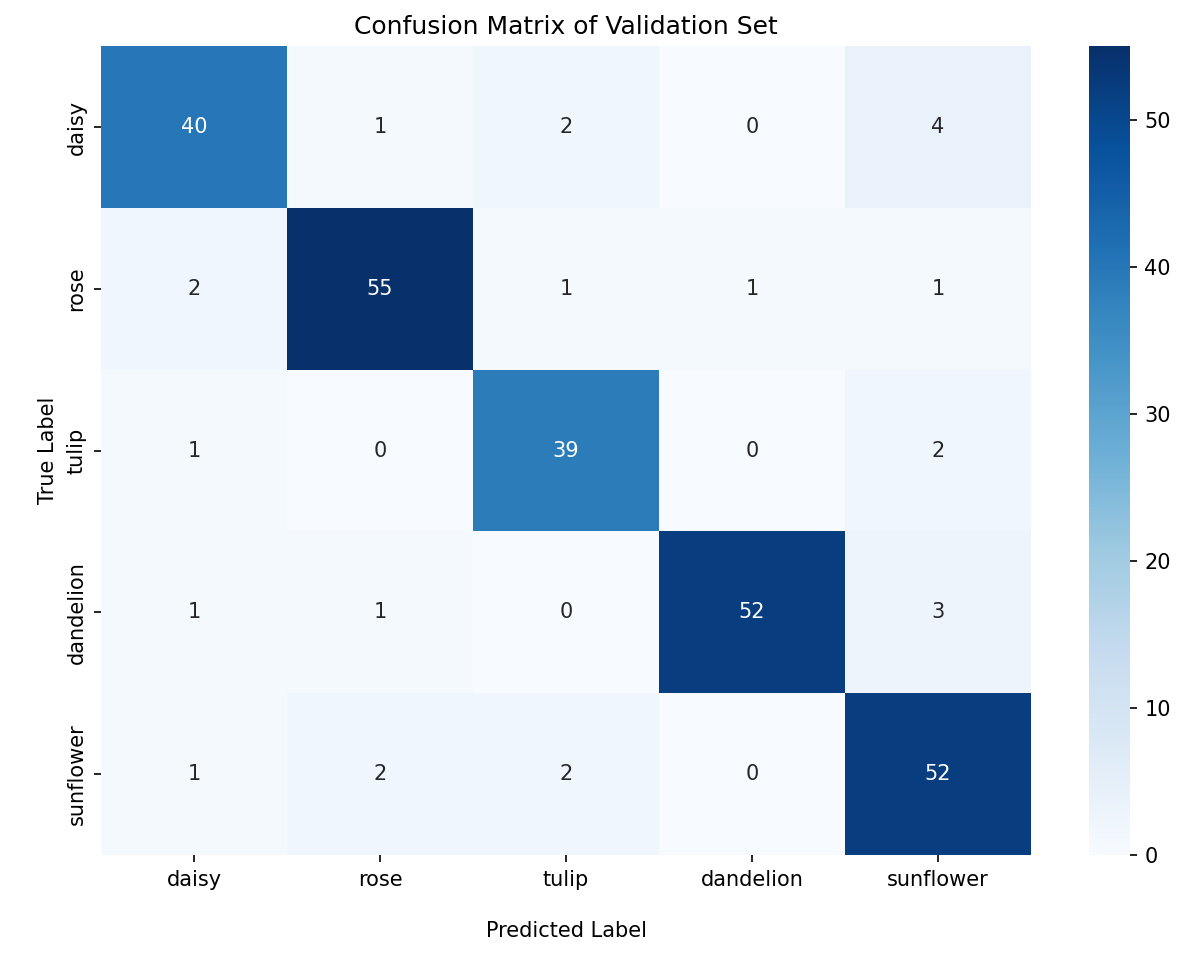

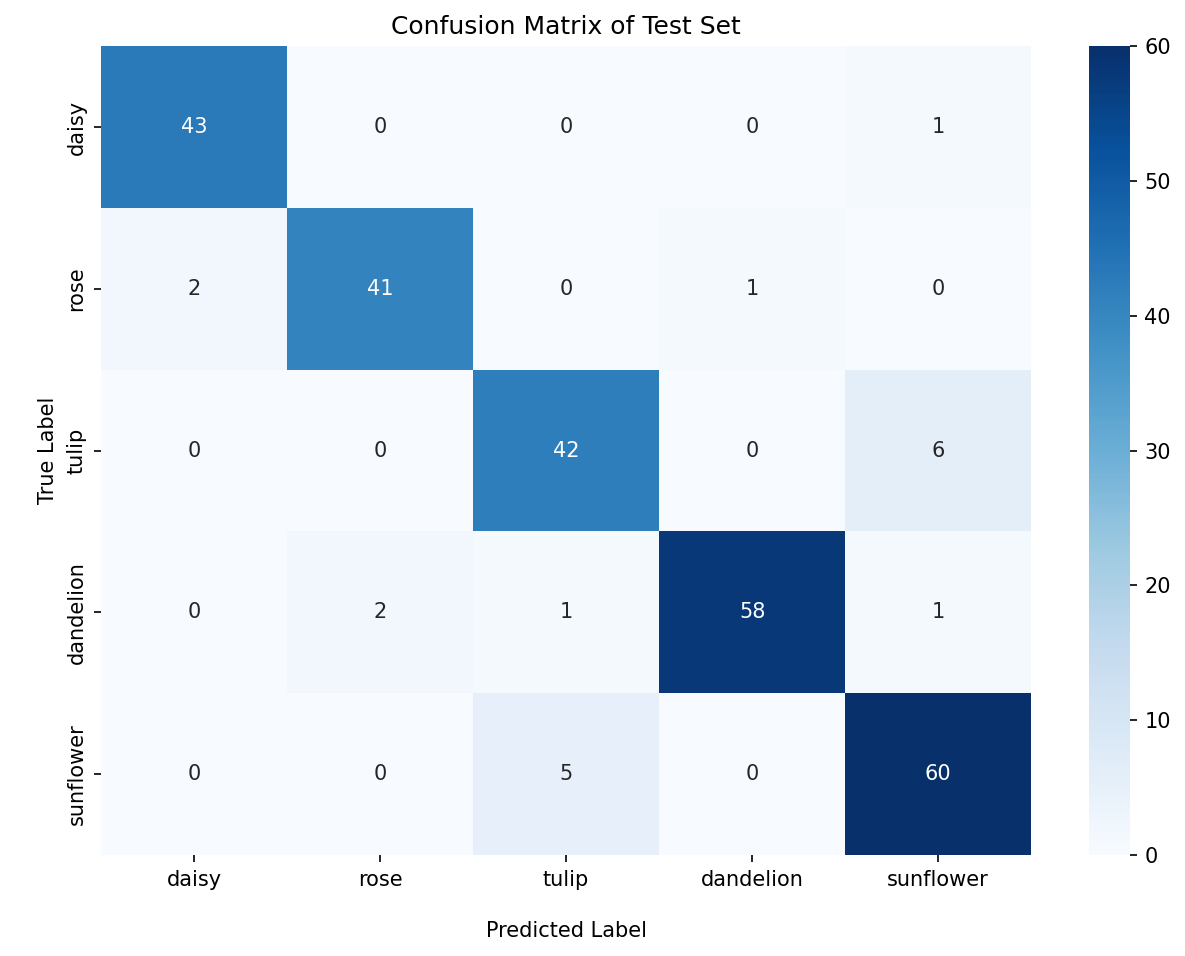

Num of Parameters: 725061


In [ ]:
# Plot the results
print(evaluate(modelsq, test_loader))
plot_accuracies(historysq)
plot_losses(historysq)
cmsq = compute_confusion_matrix(modelsq, val_loader)
plot_confusion_matrix(cmsq, classes, 'Validation Set')
cm_testsq = compute_confusion_matrix(modelsq, test_loader)
plot_confusion_matrix(cm_testsq, classes, 'Test Set')
model_complexity(SqueezeNetModel(num_classes=5))